### Stock Predictions using KERAS TUNER with LSTM

LSTM is a type of recurrent neural network (RNN) particularly good at learning from sequences (such as time series data). It can capture long-term dependencies and patterns in time series data, making it suitable for tasks like stock price predictions.

Pros: Sequence Memory, Flexibility Cons: Complexity, Overfitting



KERAS TUNER is a library for scalable hyperparameter tuning, that chooses the best set of hyperparameters for your neural network. It's specifically designed for tuning KERAS models within the TensorFlow framework. 
    PROS: Ease of use, Flexible tuning strategies, Automated tuning
    CONS: Resource intensive, Overfitting risk, Complex setup, Only for KERAS
    

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras_tuner import RandomSearch
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime
import sqlite3
from sklearn.preprocessing import StandardScaler


###  Create DataFrame with SQL lite

In [2]:
# Retrieve data
ticker = 'AAPL'
end_date = datetime.now().strftime('%Y-%m-%d')
data = yf.download(ticker, start='2020-01-01', end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
# Create connection to sqlite
conn = sqlite3.connect(':memory:')

# Store data in table
data.to_sql('stock_prices', conn, if_exists='replace', index=True)


1159

In [4]:
# Retrieve data from sqlite
query = "SELECT* FROM stock_prices"
df = pd.read_sql(query, conn)
df['Date'] = pd.to_datetime(df['Date'])
del df['Adj Close']

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,135480400
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,146322800
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,118387200
3,2020-01-07,74.959999,75.224998,74.370003,74.597504,108872000
4,2020-01-08,74.290001,76.110001,74.290001,75.797501,132079200


<Axes: >

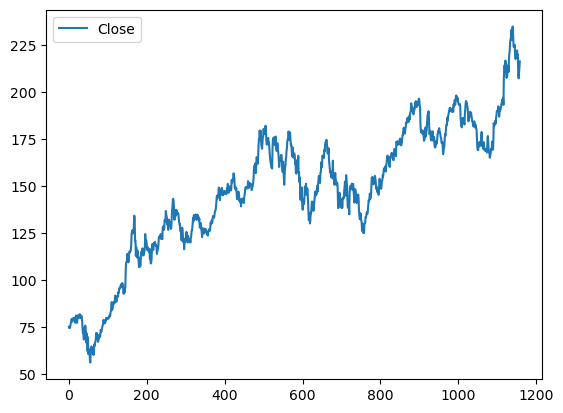

In [6]:
df.plot.line(y="Close")

In [7]:
# Creating 'Next Days Close'column, shift(-1) shifts data in the 'Close' column
# up by one position (Next Days Close will have tomorrows closing price today)

df["Next Days Close"] = df['Close'].shift(-1)

# Create 'change' column to compare values of 'Next Days Close' with 'Close'
# Change boolean value to integer

df['change'] = (df['Next Days Close'] > df['Close']).astype(int)


In [8]:
df.tail()

,Date,Open,High,Low,Close,Volume,Next Days Close,change
1154,2024-08-05,199.089996,213.500000,196.000000,209.270004,119548600,207.229996,0
1155,2024-08-06,205.300003,209.990005,201.070007,207.229996,69660500,209.820007,1
1156,2024-08-07,206.899994,213.639999,206.389999,209.820007,63516400,213.309998,1
1157,2024-08-08,213.110001,214.199997,208.830002,213.309998,47161100,216.240005,1
1158,2024-08-09,212.100006,216.779999,211.970001,216.240005,42171700,NaN,0


In [9]:
# Preprocess data: Selecting 'Close' price and scaling
# Converting 'Close'column from pandas dataframe to numpy array

data = df[['Close']].values  

# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)  # Now data_scaled is 2D


In [30]:
# Save the scaler to a .pkl file
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [10]:
# Function to create sequences or windows of historical data
# along with the target variable 'y'(predictive model forecast attempt)
# based on prior observations

def create_dataset(data, time_step=10):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]   # X data
        X.append(a)
        Y.append(data[i + time_step, 0]) # Y label
    return np.array(X), np.array(Y)

time_step = 10 # see markdown notes
X, y = create_dataset(data_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # Reshape for LSTM [samples, time steps, features]

Time Step: This parameter defines the window of recent data points that the model should consider for predicting the next point in the sequence. In practical terms, if you set 'time_step = 10', the model will use the past 10 data points to make a prediction about the next data point.


In [11]:
# X = input features, y = target values. test_size 0.2, 20% of the data is resevered
# for test set, 80% for training. Shuffle=false maintains order of the data chronologically


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [12]:
# Function to define and Tune the LSTM Model using Keras Tuner 
# 
def build_model(hp):
    model = Sequential() # model is a linear stack of layers
    model.add(LSTM(
        units=hp.Int('units', min_value=50, max_value=200, step=50),
        return_sequences=True,
        input_shape=(X_train.shape[1], 1)
    ))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=50, max_value=200, step=50), return_sequences=False))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

The number of units is a tunable hyperparameter, with a range set from 50 to 200. The step size of 50 means that the tuner will increment the number of units by 50 at each step. This stepping helps in exploring different model capacities systematically without making the tuning excessively fine-grained, Dropout randomly sets a fraction of the input units to 0 at each update during training time to prevent overfitting. The output layer with a single neuron. Since it uses a default linear activation function ('None'specified), this setup is typical for regression tasks like predicting a value (e.g., stock price).

In [13]:
# Setup Keras Tuner with RandomSearch method

tuner = RandomSearch(        # Finds the best parameters for a particular model by randomly selecting combinations of parameters from a specified range
    build_model,             # Function we made for LSTM model
    objective='val_loss',    # Objective for the tuner to minimize
    max_trials=5,            # Number of hyperparameter sets tuner will try
    executions_per_trial=3,  # Each set of hyperparameters will be used to train a model 3 times. 
    directory='model_tuning',# The directory where the tuner will save its progress and results.
    project_name='StockPricePrediction'
)
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Reloading Tuner from model_tuning/StockPricePrediction/tuner0.json


In [14]:
# Get the best model

best_model = tuner.get_best_models(num_models=1)[0]


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [15]:
# Using best performing model to train the data
# For each epoch, the model iterates over the entire training data in batches of 32 samples.

best_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0046 - val_mean_squared_error: 0.0046
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 7.8289e-04 - val_mean_squared_error: 7.8289e-04
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 7.4020e-04 - val_mean_squared_error: 7.4020e-04
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_l

In [16]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

predictions = best_model.predict(X_test).flatten()
mse = mean_squared_error(y_test, predictions)
r_squared = r2_score(y_test, predictions)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


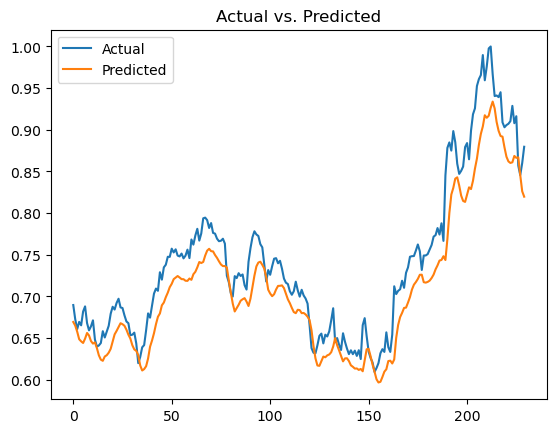

In [17]:
# Plotting actual vs predicted values
# This shows the correlation between Actual values and Predicted Values
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
predictions_df.plot(title='Actual vs. Predicted')
plt.show()

In [18]:


from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [19]:
# Make predictions
predictions = best_model.predict(X_test).flatten()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


<Axes: >

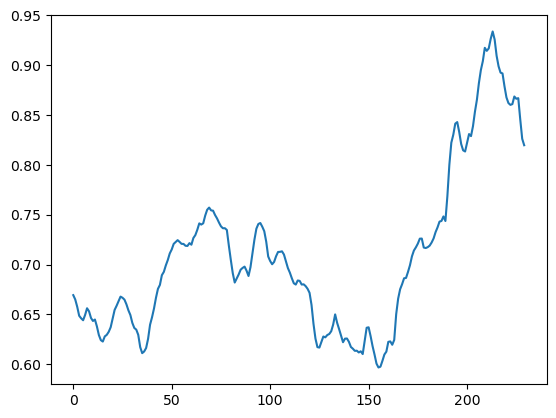

In [20]:
pd.Series(predictions).plot()

In [21]:
# Evaluate the model with regression metrics

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
r_squared = r2_score(y_test, predictions)

# Display results
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R-squared: {r_squared}')


MSE: 0.0013880774071301648
RMSE: 0.0372569108640285
MAE: 0.031685501013019673
R-squared: 0.8410303151179174


Mean Squared Error is the average of the squares of the differences between the actual and predicted values. It gives an idea of the magnitude of error made by the model.A lower MSE indicates a better fit

RMSE is a standard way to measure the error of a model in predicting quantitative data.It is commonly used in regression analysis to verify experimental results. A value of 0 would mean perfect predictions with no errors. 

MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. Similar to RMSE, a lower MAE is better as it indicates more precise predictions. 

R-square, is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. The higher the R-squared (R²) measures the proportion of variance in the dependent variable (stock price change) that is predictable from the independent variables (features in your model).An R-squared of 0.9496328576691679 suggests that approximately 94.96% of the data fit the regression model.

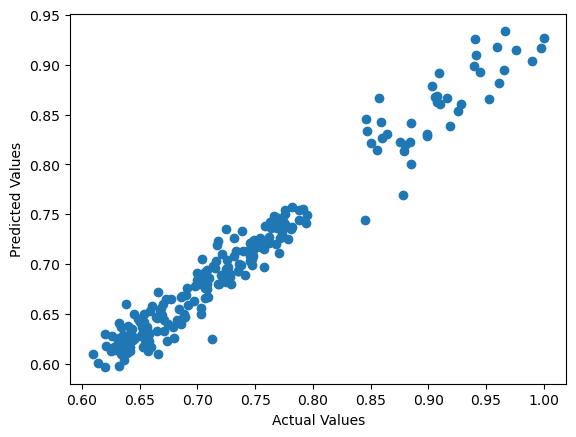

In [22]:
plt.scatter(y_test, predictions)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.plot();

If the dots are the same spot of the x,y axis then the prdiction was true , EX. if a dot was on the 0.5 x-axis AND 0.5 y-axis , THEN the prediction was correct. 

In [23]:
# Make prediction for the next day

latest_data = data_scaled[-time_step:].reshape(1, time_step, 1)
next_day_prediction = best_model.predict(latest_data)[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [24]:
# Prepare the scaler and data (repeating the earlier steps)

scaler = MinMaxScaler(feature_range=(0, 1))
data = df[['Close']].values  # Extracting closing prices
data_scaled = scaler.fit_transform(data)  # Scaling the data

# Extract the last sequence from the scaled data
time_step = 10  # Make sure time_step is defined
latest_data = data_scaled[-time_step:].reshape(1, time_step, 1)  # Reshape for LSTM input

# Loading the trained model 
next_day_prediction = best_model.predict(latest_data)[0][0]
prev_day_price = latest_data[0][-1][0]
# # Interpret the prediction
if next_day_prediction > prev_day_price:
    print("The model predicts that the stock price will increase the next day.")
else:
    print("The model predicts that the stock price will decrease the next day.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
The model predicts that the stock price will decrease the next day.


In [25]:
next_day_price = scaler.inverse_transform([[next_day_prediction]])[0][0]
print(f"Next day predicted stock price: ${next_day_price:.2f}")


Next day predicted stock price: $205.55


In [26]:
data[-1]

array([216.24000549])

In [28]:
# Export our model to HDF5 file
best_model.save("trained_model.keras")


In [31]:
import joblib
from tensorflow.keras.models import load_model

# Load the scaler
scaler = joblib.load('scaler.pkl')

# Load the trained model
best_model = load_model('trained_model.keras')

# Example: Prepare new data for prediction
latest_data = data_scaled[-time_step:].reshape(1, time_step, 1)
next_day_prediction = best_model.predict(latest_data)[0][0]

# Inverse transform to get the original scale
next_day_price = scaler.inverse_transform([[next_day_prediction]])[0][0]
print(f"Next day predicted stock price: ${next_day_price:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Next day predicted stock price: $205.55
